# Compare Voice Activity Detection Pipelines

In this notebook, different Voice Activity Detection (VAD) pipelines will be compared in terms of performance. The following pipelines will be compared:

- openSMILE voice probability from `pitch.acf` with 0.5 onset probability and 0.25 offset probability
- openSMILE voice probability with postprocessing from [SpeechBrain](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.pretrained.interfaces.html#speechbrain.pretrained.interfaces.VAD)'s VAD pipeline as in `VAD.merge_close_segments()` and `VAD.remove_short_segments()` with default arguments
- [SpeechBrain](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.pretrained.interfaces.html#speechbrain.pretrained.interfaces.VAD) pretrained VAD pipeline as in `VAD.get_speech_segments()` with default arguments
- pyannotes pretrained VAD pipeline `pyannote/voice-activity-detection` with default arguments

The pipelines will be compared on three metrics (detection error rate, detection cost funciton, and detection F1) as described [here](https://pyannote.github.io/pyannote-metrics/reference.html#detection).

In [2]:
""" Compare VAD performance of different pipelines """
from rttm import RttmSeq, RttmObj, read_rttm
from pyannote.core import Timeline, Segment
from pyannote.metrics.detection import DetectionErrorRate, DetectionCostFunction, DetectionPrecisionRecallFMeasure
import seaborn as sns
import pandas as pd
import numpy as np
import os

RESULTS = ["opensmile", "opensmile_speechbrain", "speechbrain", "pyannote"]


In [3]:
def convert_rttm_timeline(rttm_seq):
    timeline = Timeline()
    for seg in rttm_seq.sequence:
        timeline.add(Segment(seg.tbeg, seg.tbeg+seg.tdur))

    return timeline.to_annotation()


In [4]:
timelines = {}

for res_dir in RESULTS + ["reference"]:
    out = []
    with os.scandir(os.path.join("results", res_dir)) as filenames:
        for filename in filenames:
            rttm_seq = read_rttm(filename.path)
            out.append(convert_rttm_timeline(rttm_seq))

    timelines[res_dir] = out


In [5]:
detection_error = DetectionErrorRate()
detection_cost = DetectionCostFunction()
detection_f1 = DetectionPrecisionRecallFMeasure()


In [6]:
results = {"error": {}, "cost": {}, "f1": {}}

for res_dir in RESULTS:
    error = []
    cost = []
    f1 = []

    for i, hypothesis in enumerate(timelines[res_dir]):
        reference = timelines["reference"][i]
        error.append(detection_error(reference, hypothesis))
        cost.append(detection_cost(reference, hypothesis))
        f1.append(detection_f1(reference, hypothesis))

    results["error"][res_dir] = error
    results["cost"][res_dir] = cost
    results["f1"][res_dir] = f1


c:\Users\MalteLuken\Repositories\mexca-sd-experiment\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [7]:
results_df = {"metric": [], "method": [], "value": []}

method_labels = {"opensmile": "os", "opensmile_speechbrain": "os+sb",
                 "speechbrain": "sb", "pyannote": "pa"}

for metric in results.keys():
    for method in RESULTS:
        for val in results[metric][method]:
            results_df["metric"].append(metric)
            results_df["method"].append(method_labels[method])
            results_df["value"].append(val)

results_df = pd.DataFrame(results_df)


In [8]:
def select_min_max(group):
    if pd.DataFrame(group).reset_index()["metric"].apply(lambda x: x in ["cost", "error"]).all():
        return np.min(group)
    else:
        return np.max(group)

In [9]:
mean_results_df = results_df.groupby(["metric", "method"]).aggregate(np.mean)

mean_best_results_dict = mean_results_df.groupby(
    ["metric"]).aggregate(select_min_max).to_dict()["value"]


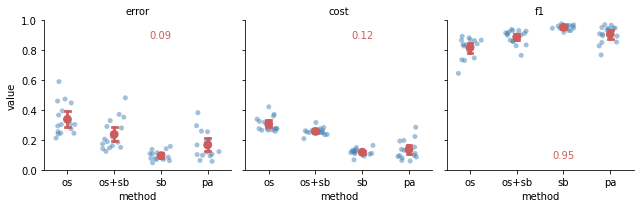

In [10]:
grid = sns.FacetGrid(data=results_df, col="metric")

grid.map(sns.stripplot, "method", "value", color="steelblue",
         order=method_labels.values(), alpha=0.5, jitter=0.25, zorder=1)
grid.map(sns.pointplot, "method", "value", color="indianred", join=False,
         order=method_labels.values(), estimator=np.mean, capsize=0.1, zorder=2)

grid.set_titles(col_template="{col_name}")
grid.set(ylim=(0.0, 1.0), yticks=np.linspace(0.0, 1.0, 6))

best_pos = {"error": (2, 0.9), "cost": (2, 0.9), "f1": (2, 0.1)}

for ax in grid.axes[0]:
    metric = ax.title.get_text()
    best = round(mean_best_results_dict[metric], 2)
    ax.annotate(text=best, xy=best_pos[metric],
                ha='center', va='center', color="indianred")

grid.savefig("vad_results.pdf")
grid.savefig("vad_results.png")


The comparison shows that the SpeechBrain pretrained VAD pipeline performs best in all three evaluation metrics. It has the lowest detection error rate, detection cost function, and highest detection F1 score. It also shows the lowest spread in all three metrics across evaluated samples. Thus, the SpeechBrain VAD pipeline is the best candidate for MEXCA.

EDIT: The speaker diarization based on the Speechbrain VAD segments seems to not perform very well. This could be due to the number of segments (and the segment length) detected by the VAD pipeline. Thus, the number of detected speech segments will be compared across pipelines.

In [42]:
n_segments_df = {"method": [], "ratio": []}

for res_dir in RESULTS:
    for i, hypothesis in enumerate(timelines[res_dir]):
        reference = timelines["reference"][i]
        n_segments_df["method"].append(method_labels[res_dir])
        n_segments_df["ratio"].append(np.log(len(hypothesis)/len(reference)))

n_segments_df = pd.DataFrame(n_segments_df)

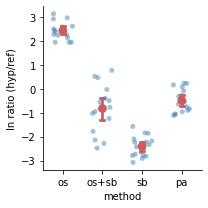

In [46]:
grid = sns.FacetGrid(data=n_segments_df)

grid.map(sns.stripplot, "method", "ratio", color="steelblue",
         order=method_labels.values(), alpha=0.5, jitter=0.25, zorder=1)
grid.map(sns.pointplot, "method", "ratio", color="indianred", join=False,
         order=method_labels.values(), estimator=np.mean, capsize=0.1, zorder=2)

grid.set(ylabel="ln ratio (hyp/ref)")

grid.savefig("vad_n_segments_ratio.pdf")
grid.savefig("vad_n_segments_ratio.png")

Here, the log ratio between detected speech segments and reference speech segments is shown. The figure shows that pyannote detects the most similar amount of speech segments to the reference. Thus, it might be beneficial to choose pyannote for Mexca because the assignment to speakers can be more finegrained (and hence more accurate) compared to Speechbrain.